# Stocks calibration: NVDA

In [35]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
import scipy.optimize as scpo
import sys
import time
import warnings
sys.path.append('C:/Users\ornel\PycharmProjects\Margin-Loans-Pricing/functions')
sys.path.append('C:/Users/ornel/PycharmProjects/Margin-Loans-Pricing/calibration')


from IPython.display import display
warnings.simplefilter(action='ignore', category=FutureWarning)

from BSpricer import BS_Pricer
from MERTONpricer import Merton_pricer
from KOUpricer import Kou_pricer
from VGpricer import VG_pricer

np.random.seed(110)

In [36]:
otko_spx = pd.read_csv('../../data/SPX/otko_spx_1year.csv')
print('>> SPX')
print(otko_spx)

scale_factors = {
    'AAPL': 7.84,
    'META': 6.23,
    'TSLA': 10.35,
    'NVDA': 10.7
}
columns = ['BID(%)', 'ASK(%)', 'Midpoint(%)']

# FIND PRICES OF OTKO OPTIONS ACCORDING to their scale factors
otko_nvda = otko_spx.copy()

otko_nvda[columns] = round(otko_nvda[columns]*scale_factors['AAPL'],2)
otko_nvda['Stock Name'] = 'NVDA'
print(f'>> NVDA\n {otko_nvda}')

#otko_nvda.to_csv('../../data/NVDA/nvda_otko_1year.csv', index=False)

>> SPX
  Starting date Stock Name Expiry  K1  K2  BID(%)  Midpoint(%)  ASK(%)
0    20/01/2016        SPX     1Y  75   0    0.17        0.185    0.20
1    20/01/2016        SPX     1Y  70   0    0.08        0.090    0.10
2    20/01/2016        SPX     1Y  85  75    0.34        0.370    0.40
3    20/01/2016        SPX     1Y  80  70    0.24        0.260    0.28
4    20/01/2016        SPX     1Y  90  80    0.48        0.510    0.54
>> NVDA
   Starting date Stock Name Expiry  K1  K2  BID(%)  Midpoint(%)  ASK(%)
0    20/01/2016       NVDA     1Y  75   0    1.33         1.45    1.57
1    20/01/2016       NVDA     1Y  70   0    0.63         0.71    0.78
2    20/01/2016       NVDA     1Y  85  75    2.67         2.90    3.14
3    20/01/2016       NVDA     1Y  80  70    1.88         2.04    2.20
4    20/01/2016       NVDA     1Y  90  80    3.76         4.00    4.23


In [37]:
# Define the instruments to download.
tickers = ['NVDA']      # AAPL, META, TSLA, MSFT, NVDA, GOOG

######## FIRST TIME, THEN SAVED INTO A CSV FILE ##########
# Take all available data from 20/01/2016 until 20/01/2018.
start_date = datetime(2016, 1, 20)
end_date = datetime(2018, 1, 20)

# Use pandas_reader.data.DataReader to load the data.
stocks_data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)
#spx_data = yf.download('^GSPC', start=start_date, end=end_date, auto_adjust=True)

print(stocks_data.head(3))

S0 = stocks_data.loc['2016-01-20', 'Close']
print(S0)

[*********************100%%**********************]  1 of 1 completed
                Open      High       Low     Close    Volume
Date                                                        
2016-01-20  6.544408  6.793393  6.456531  6.707957  48118000
2016-01-21  6.781189  6.891035  6.642049  6.786070  48145600
2016-01-22  6.915446  6.991118  6.900800  6.944738  25799600
6.707956790924072


### Calibration of model parameters
The following code snippet perfoms calibration of the models parameters using closed forms.
If we define $\Theta$ the set of parameters, the goal is to find the optimal parameters $\Theta^*$ that minimize the following objective function:
$$ \sum_{i=1}^{N} w_i \biggl( P_i - f(K_i|\Theta) \biggr)^2 $$
where $w_i$ are weights, usually defined as
$$ w_i = \frac{1}{\text {spread}_i^2 },$$ $P_i$ are the market prices and $f$ is the pricing function, $f$ given by **Merton** Jump Diffusion model, **Kou** Jump Diffusion model, or **Variance Gamma** process. The optimization problem is carried out using the module *least_squares* of the library `scipy.optimize`.
Let's define the spread first.

#### NVDA PRICES

In [38]:
r = 0.03
T = 1
q = 0
exercise = 'european'
paths = 1000
days = 252

# BOOK:  Financial modelling with jump processes  PAG 442
strikes = otko_spx[['K1', 'K2']].values / 100
weights =  1/(otko_nvda['ASK(%)'] - otko_nvda['BID(%)'])**2
mkt_prices = otko_nvda['Midpoint(%)'].values

##### Merton Jump Diffusion model

In [39]:
x0 = [0.26, 0.3, -0.3, 0.5]
bounds = ( [1e-3, 0, -2, 0], [2, 10, 5, 10] )

def cost_function(x, strikes, mkt_prices):
    sigma, lambd, meanJ, stdJ = x
    M = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
    sq_err = 0
    for k in range(len(strikes)):
        sq_err +=  weights[k]*(M.closed_formula_otko(strikes[k][0], strikes[k][1]) - mkt_prices[k])**2
    return sq_err

start = time.time()
mert = scpo.least_squares(cost_function, x0, args=(strikes, mkt_prices), bounds=bounds, method = 'trf', verbose=1)
end = time.time()

mert_params_calibrated = [round(p,4) for p in mert.x[:4]]

The maximum number of function evaluations is exceeded.
Function evaluations 400, initial cost 2.8593e+04, final cost 8.0890e-04, first-order optimality 1.85e-01.


In [40]:
print('\nMETHOD: LEAST SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {mert_params_calibrated[0]} \t {round(mert_params_calibrated[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert_params_calibrated[1],2))
print('> Calibrated Jump Mean = ', round(mert_params_calibrated[2],3))
print('> Calibrated Jump St. dev.  = ', round(mert_params_calibrated[3],3))
print(f'TIME ELAPSED:  {round(end-start,2)} sec')


METHOD: LEAST SQUARES (trf)
> Calibrated Volatlity [σ] = 0.26 	 26.0%
> Calibrated Jump intensity [λ] =  2.93
> Calibrated Jump Mean =  0.028
> Calibrated Jump St. dev.  =  0.226
TIME ELAPSED:  4.02 sec


In [41]:
print(f'CALIBRATED PARAMETERS [σ\t\tλ\t\tm\t\tv]')
print(f'> OTKO DC:\t\t\t {mert_params_calibrated}')
otko_mert_params_nvda = mert_params_calibrated
%store otko_mert_params_nvda

CALIBRATED PARAMETERS [σ		λ		m		v]
> OTKO DC:			 [0.26, 2.9345, 0.0281, 0.2255]
Stored 'otko_mert_params_nvda' (list)


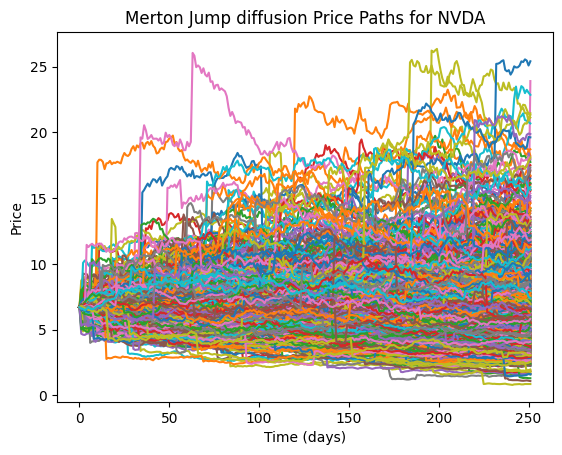

<Figure size 1000x600 with 0 Axes>

In [42]:
sigma_c, lambd_c, meanJ_c, stdJ_c = mert_params_calibrated
MERT_CAL = Merton_pricer(S0, None, T, r, q, sigma_c, lambd_c, meanJ_c, stdJ_c, exercise)
SMerton_CAL = MERT_CAL.MertonPath(days, paths)
MERT_CAL.plotMertonPath(SMerton_CAL, 'NVDA')

##### Kou Double Exponential Jump Diffusion model

In [43]:
# initial guess: [σ, λ, p, η_1, η_2]
x0 =[0.3, 2, 0.4, 10, 15]
bounds = ( [1e-3, 1e-4, 0.4, 0, 0], [2, 6, 1, 20, 50] )

# Define the objective function
def cost_function(x, strikes, mkt_prices):
    sigm, lamb, p, eta1, eta2 = x
    KOU = Kou_pricer(S0=S0, K=strikes, ttm=T, r=r, sigma=sigm, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    sq_err = 0
    for k in [2,3,4]:
        sq_err += weights[k]*(KOU.closed_formula_otko(strikes[k][0], strikes[k][1]) - mkt_prices[k]) ** 2
    return sq_err

start2=time.time()
kou2 = scpo.least_squares(cost_function, x0, args=(strikes, mkt_prices),  method='trf', bounds=bounds, verbose=1)
end2=time.time()

kou_params_calibrated = kou2.x[:5]

C:\Users\ornel\PycharmProjects\Margin-Loans-Pricing\venv\Lib\site-packages\scipy\optimize\_lsq\trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
C:\Users\ornel\PycharmProjects\Margin-Loans-Pricing\venv\Lib\site-packages\scipy\optimize\_lsq\common.py:113: RuntimeWarning: invalid value encountered in divide
  p_norm = norm(suf / denom)
C:\Users\ornel\PycharmProjects\Margin-Loans-Pricing\venv\Lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: invalid value encountered in divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\ornel\PycharmProjects\Margin-Loans-Pricing\venv\Lib\site-packages\scipy\optimize\_lsq\common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
C:\Users\ornel\PycharmProjects\Margin-Loans-Pricing\venv\Lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: invalid value encountered in scalar divide

The maximum number of function evaluations is exceeded.
Function evaluations 500, initial cost 6.8970e+03, final cost 1.3001e-05, first-order optimality 9.02e-05.


In [44]:
print('METHOD 2: Least-squares')
print(f'> Calibrated Volatlity [σ] = {round(kou_params_calibrated[0],4)} \t {round(kou_params_calibrated[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(kou_params_calibrated[1],2))
print(f'> Calibrated Upward Jump probability [p] = {round(kou_params_calibrated[2],2)}, [q] = {round(1-kou_params_calibrated[2],2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(kou_params_calibrated[3],2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(kou_params_calibrated[4],2))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

METHOD 2: Least-squares
> Calibrated Volatlity [σ] = 0.3 	 30.0%
> Calibrated Jump intensity [λ] =  4.8
> Calibrated Upward Jump probability [p] = 0.4, [q] = 0.6
> Calibrated Rate of Exp. 1  [η_1] =  10.0
> Calibrated Rate of Exp. 2  [η_2] =  5.45
TIME ELAPSED:  0.42 sec


In [45]:
print(f'CALIBRATED PARAMETERS:\t [σ\t\tλ\t\tp\t\tη1\t η2\t   ]')
print(f'> OTKO DC:\t\t\t\t {[round(p,4) for p in kou_params_calibrated]}')
otko_kou_params_nvda = kou_params_calibrated
%store otko_kou_params_nvda

CALIBRATED PARAMETERS:	 [σ		λ		p		η1	 η2	   ]
> OTKO DC:				 [0.3, 4.8006, 0.4, 10.0, 5.4461]
Stored 'otko_kou_params_nvda' (ndarray)


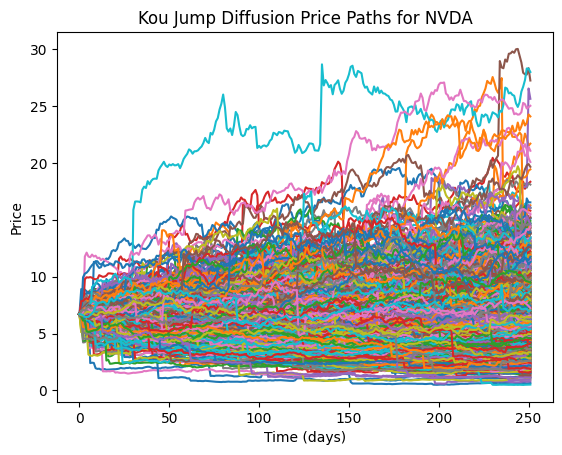

<Figure size 1000x600 with 0 Axes>

In [46]:
sigma, lambd, p, eta1, eta2 = kou_params_calibrated
KOU_CAL = Kou_pricer(S0, None, T, r, sigma, lambd, p, eta1, eta2, exercise)
SKou_CAL = KOU_CAL.KouPath(days, paths)
KOU_CAL.plotKouPath(SKou_CAL, 'NVDA')

##### Variance Gamma model

In [47]:
x0 =[0.18, -0.475, 1.0]  # initial guess: [σ, θ, v]
bounds = ( [1e-3, -5, 0], [1, 2, 4] )

def cost_function(x, strikes, mkt_prices):
    sigma, theta, nu = x
    VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
    sq_err = 0
    for k in [0,1,2,3,4]:
        sq_err += weights[k]*(VG.closed_formula_otko6(strikes[k][0], strikes[k][1]) - mkt_prices[k]) ** 2
    return sq_err

start3=time.time()
vg = scpo.least_squares(cost_function, x0, args=(strikes, mkt_prices),  method='trf', bounds=bounds, verbose=1)
end3=time.time()

vg_params_calibrated = [round(p,4) for p in vg.x[:3]]

The maximum number of function evaluations is exceeded.
Function evaluations 300, initial cost 8.6145e+05, final cost 4.8705e-01, first-order optimality 4.93e+00.


In [48]:
print('METHOD 1: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {vg_params_calibrated[0]}, \t {round(vg_params_calibrated[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params_calibrated[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params_calibrated[2])
print(f'TIME ELAPSED:  {round(end3-start3,2)} sec')

METHOD 1: LEAST-SQUARES (trf)
> Calibrated Volatlity [σ] = 0.4737, 	 47.37%
> Calibrated mean rate gamma process [θ] =  0.1965
> Calibrated variance rate gamma process [v]=  0.3018
TIME ELAPSED:  0.3 sec


In [49]:
print(f'CALIBRATED PARAMETERS: [σ \t\tθ\t\t v]')
print(f'> OTKO DC:\t\t\t {vg_params_calibrated}')
otko_vg_params_nvda = vg_params_calibrated
%store otko_vg_params_nvda

CALIBRATED PARAMETERS: [σ 		θ		 v]
> OTKO DC:			 [0.4737, 0.1965, 0.3018]
Stored 'otko_vg_params_nvda' (list)


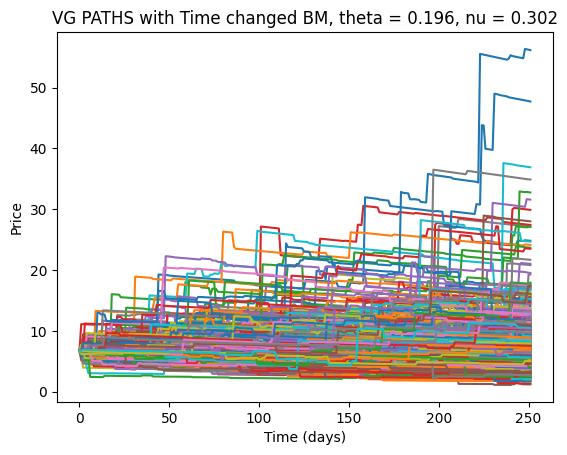

<Figure size 800x600 with 0 Axes>

In [50]:
sigma, theta, nu = vg_params_calibrated
VG_CAL = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
SVarGamma_cal = VG_CAL.VarianceGammaPath1(days, paths)
VG_CAL.plotVGPath(SVarGamma_cal, 'NVDA', 'Time changed BM')

### Repricing options with calibrated parameters

In [51]:
calibrated_prices = pd.DataFrame({
    'K1': otko_nvda['K1'],
    'K2': otko_nvda['K2'],
    'MKT_BID (%)': otko_nvda['BID(%)'],
    'MKT_MID (%)': otko_nvda['Midpoint(%)'],
    'MKT_ASK (%)': otko_nvda['ASK(%)']
})
print(f'MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. \n\n{calibrated_prices}')

MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. 

   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)
0  75   0         1.33         1.45         1.57
1  70   0         0.63         0.71         0.78
2  85  75         2.67         2.90         3.14
3  80  70         1.88         2.04         2.20
4  90  80         3.76         4.00         4.23


##### Merton Jump diffusion


In [52]:
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SMerton_CAL.T:
        payoffs.append(MERT_CAL.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(calibrated_prices))
merton_cf_prices = np.zeros(len(calibrated_prices))

for index in range(len(calibrated_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    merton_cf_prices[index] = MERT_CAL.closed_formula_otko(strikes[index][0], strikes[index][1])

calibrated_prices['MERTON MC (%)'] = [round(p,2) for p in merton_mc_prices]
calibrated_prices['MERTON CF (%)'] = [round(p,2) for p in merton_cf_prices]

##### Kou Double Exponential Jump diffusion

In [53]:
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SKou_CAL.T:
        payoffs.append(KOU_CAL.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(calibrated_prices))
kou_cf_prices = np.zeros(len(calibrated_prices))

for index in range(len(calibrated_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    kou_cf_prices[index] = KOU_CAL.closed_formula_otko(strikes[index][0], strikes[index][1])

calibrated_prices['KOU MC (%)'] = [round(p,2) for p in kou_mc_prices]
calibrated_prices['KOU CF (%)'] = [round(p,2) for p in kou_cf_prices]

##### Variance Gamma Jump diffusion

In [54]:
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SVarGamma_cal.T:
        payoffs.append(VG_CAL.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(calibrated_prices))
vg_cf_prices = np.zeros(len(calibrated_prices))

for index in range(len(calibrated_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] *100
    vg_cf_prices[index] = VG_CAL.closed_formula_otko6(strikes[index][0], strikes[index][1])

calibrated_prices['VG MC (%)'] = [round(p,2) for p in vg_mc_prices]
calibrated_prices['VG CF (%)'] = [round(p,2) for p in vg_cf_prices]

In [55]:
print(f'>> SPX OTKO OPTIONS REPRICED WITH CALIBRATED PARAMETERS\nMC = Monte Carlo pricing\nCF = Closed Formulas pricing\n')
print(calibrated_prices)

>> SPX OTKO OPTIONS REPRICED WITH CALIBRATED PARAMETERS
MC = Monte Carlo pricing
CF = Closed Formulas pricing

   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)  MERTON MC (%)  \
0  75   0         1.33         1.45         1.57           1.49   
1  70   0         0.63         0.71         0.78           0.76   
2  85  75         2.67         2.90         3.14           2.71   
3  80  70         1.88         2.04         2.20           1.88   
4  90  80         3.76         4.00         4.23           3.76   

   MERTON CF (%)  KOU MC (%)  KOU CF (%)  VG MC (%)  VG CF (%)  
0           1.46        4.90        2.37       1.62       1.44  
1           0.71        3.27        1.54       0.85       0.79  
2           2.96        5.00        2.89       3.00       2.82  
3           2.00        3.90        2.06       1.99       1.78  
4           3.98        5.90        3.98       4.00       4.05  
